In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import minigrid
from minigrid.core.constants import IDX_TO_OBJECT, IDX_TO_COLOR
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scripts.agents import QLearningAgent, SARSAAgent
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results
from scripts.tilecoding import QTable

### Top 3 hyperparameters for Q-Learning and SARSA

In [7]:
# Top 3 hyperparameters for Q-Learning and SARSA
qlearning_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.3,
        "tau_start": 100000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.1
    },
    # Second best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.3,
        "tau_start": 10000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.1
    },
    # Third best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.3,
        "tau_start": 100000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.3
    }
    
]

sarsa_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.1
    },
    # Second best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.3
    },
    # Third best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 1
    }
]


## Running experiments

In [3]:
class MinigridObsWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(np.array([0, 0, 0]), np.array([3, 8, 1]))

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return self.observation(obs), info

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        return self.observation(observation), reward, terminated, truncated, info

    def get_front(self, observation):
        return IDX_TO_OBJECT[observation["image"][3,5,0]]

    def is_wall(self, row, col, grid):
        if (IDX_TO_OBJECT[grid[row,col]] == "wall"):
            return 1
        else:
            return 0

    def get_agent_pos(self, observation):
        obs_grid = np.fliplr(observation["image"][:,:,0])
        num_right = self.is_wall(4,0,obs_grid) + self.is_wall(5,0,obs_grid)
        num_front = self.is_wall(3,1,obs_grid) + self.is_wall(3,2,obs_grid)

        dirn = observation["direction"]
        if dirn == 0:
            return [2-num_right, 2-num_front]
        if dirn == 1:
            return [num_front, 2-num_right]
        if dirn == 2:
            return [num_right, num_front]
        if dirn == 3:
            return [2-num_front, num_right]

    def observation(self, observation):
        
        agent_pos = self.get_agent_pos(observation)

        agent_direction = observation["direction"]
        agent_pos_encoding = 3*(agent_pos[0])+(agent_pos[1])
        agent_path_clear = (self.get_front(observation) in ["empty", "goal"])

        mod_observation = np.array([
            agent_direction, 
            agent_pos_encoding, 
            agent_path_clear
        ])
        
        return mod_observation

In [4]:
def episode_trigger(x):
    if x % 100 == 0:
        return True
    return False

In [5]:
env = gym.make('MiniGrid-Dynamic-Obstacles-5x5-v0', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/minigrid-qlearning-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

env = MinigridObsWrapper(env)

sarsa_agent = SARSAAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)


qlearning_agent = QLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

trainer = Trainer()
qlearning_results = test_agent(env, qlearning_agent, trainer, qlearning_hyperparameter_list, num_experiments=5)
sarsa_results = test_agent(env, sarsa_agent, trainer, sarsa_hyperparameter_list, num_experiments=5)

env.close()

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment1/DA6400_RL_PA1/backups/minigrid-qlearning-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.91it/s, Mean Score=0.792]


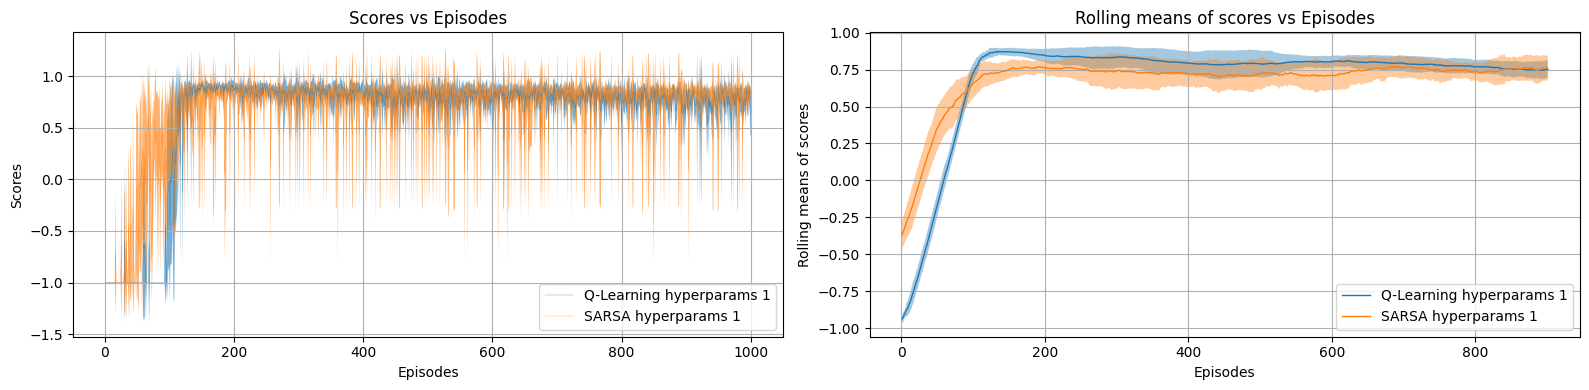

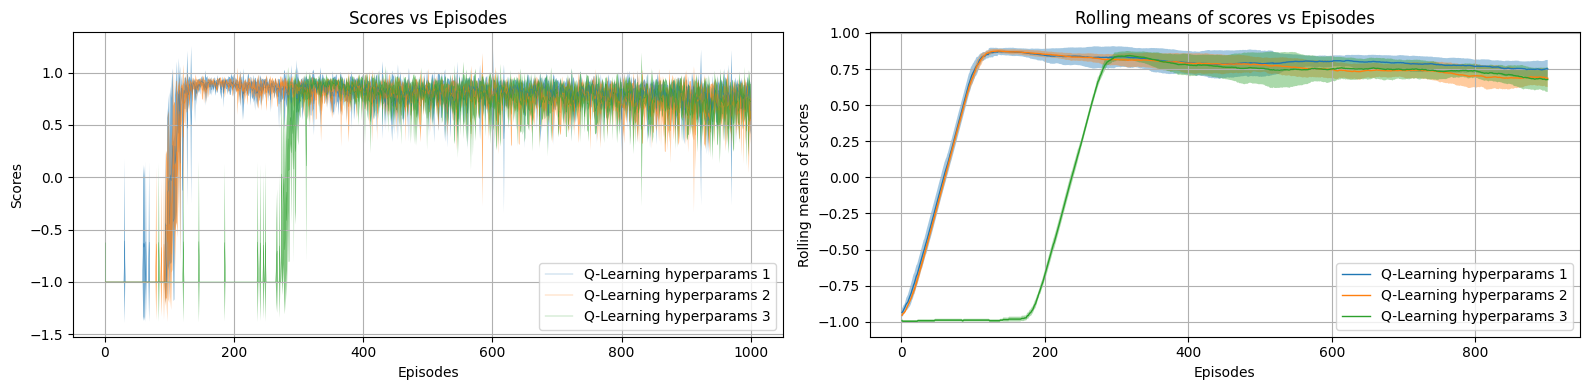

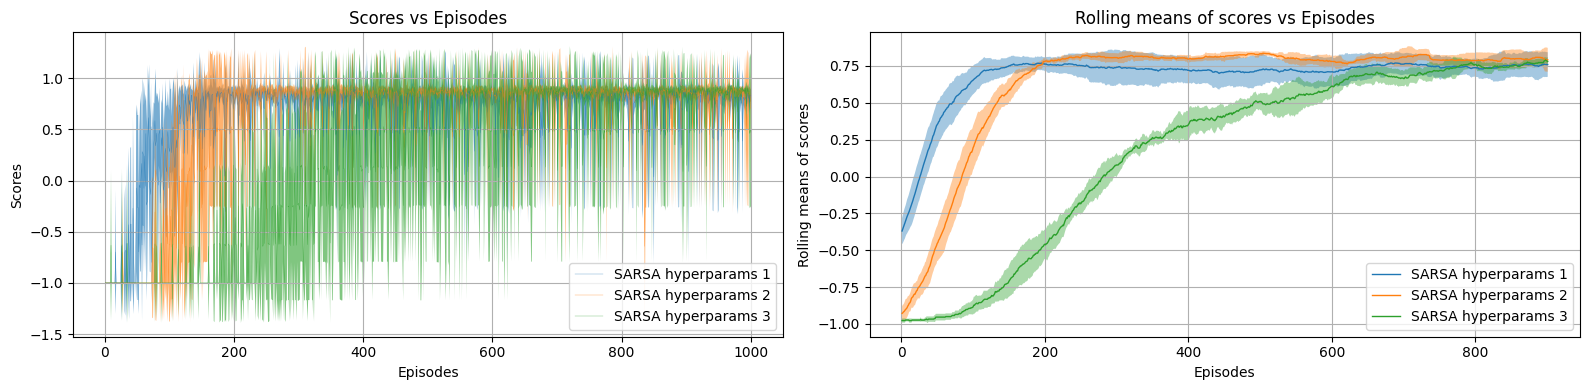

In [3]:
combined_results = qlearning_results + sarsa_results

with open("backups/minigrid-plots/minigrid_qlearning_results.pickle", 'wb') as handle:
    pickle.dump(qlearning_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("backups/minigrid-plots/minigrid_sarsa_results.pickle", 'wb') as handle:
    pickle.dump(sarsa_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

plot_test_results(combined_results, [0, 3])
plt.savefig("backups/minigrid-plots/minigrid_combined.png")
plot_test_results(qlearning_results, [0, 1, 2])
plt.savefig("backups/minigrid-plots/minigrid_qlearning.png")
plot_test_results(sarsa_results, [0, 1, 2])
plt.savefig("backups/minigrid-plots/minigrid_sarsa.png")

[0. 0. 0.] [ 2.79554225e-02  5.53303302e-06 -2.65478827e-03]


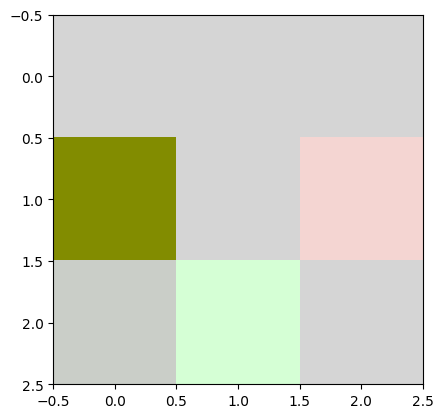

In [7]:
img = np.reshape(sarsa_agent.q_table.table, (4,9,2,3))
imx = np.reshape(img[3,:,1,:], (3,3,3))
print(imx[0,2], imx[1,2])
plt.imshow((imx-np.min(imx))/(np.max(imx)-np.min(imx)))